In [1]:
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from transformers import get_cosine_schedule_with_warmup
from src.transformations import EqualizeTransform, CenterCrop, Translate
from src.preprocessing import crop_od_fill_if_needed, make_square
import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
import cv2
import json

In [37]:
with open('original_shuffled_map.json') as fp:
    original_shuffled_map = json.load(fp)
list(original_shuffled_map.keys())[list(original_shuffled_map.values()).index("SHUF00000")]

'DEV13781.jpg'

In [39]:
shuf_yolo_dir = "labels_train_finalModel/labels_train_finalModel"
new_dir = "data/yolo_pred_train"

with open('original_shuffled_map.json') as fp:
    original_shuffled_map = json.load(fp)

for fn in os.listdir(shuf_yolo_dir):
    old_name = shuf_yolo_dir + "/" + fn 
    new_name = list(original_shuffled_map.keys())[list(original_shuffled_map.values()).index(fn[:-4])] + ".txt"
    new_name = new_dir + "/" + new_name
    os.rename(old_name, new_name)



In [2]:
class Args(object):
    def __init__(self):
        self.equalize = "no"

args = Args()
    

In [3]:
equalizer = EqualizeTransform(args)

In [4]:
train_transforms = transforms.Compose([
            equalizer,
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalizing makes it really bady visible with matplotlib
            transforms.RandomRotation((-20, 20)),
            transforms.RandomHorizontalFlip(),
            Translate(1, 0.15),
            CenterCrop(0.5),
            transforms.Resize((224, 224))
        ])

In [9]:
class ClassifierDataset(Dataset):
    def __init__(self, data_dir, img_prefix, yolo_dir, label_file, start_idx, end_idx, cache_all=False, transform=None, FACTOR: int = 1.5):
        self.data_dir = data_dir
        self.transform = transform
        self.img_prefix = img_prefix
        self.FACTOR = FACTOR
        self.cache_all = cache_all
        self.data = {}
        self.len = end_idx - start_idx
        self.label_file = label_file
        if self.label_file:
            labels = pd.read_csv(label_file, skiprows = lambda x: x not in [0] + list(range(start_idx+1, end_idx+1)))
            labels["label"] = None
            labels["label"].loc[labels["class"] == "NRG"] = 0
            labels["label"].loc[labels["class"] == "RG"] = 1
            self.labels = labels.label.to_numpy()
        self.yolo_dir = yolo_dir

        if self.cache_all:
            for idx in range(start_idx, end_idx):
                img = self._get_img(idx)
                self.data[idx] = img

    def _get_img(self, idx):
        # get filenames
        fn = self.img_prefix + str(idx).zfill(5) + ".jpg"
        yolo = fn + ".txt"
        filepath = os.path.join(self.data_dir, fn).replace("\\", "/") # replace possibly not necessary
        yolopath = os.path.join(self.yolo_dir, yolo).replace("\\", "/")

        # open files
        img = cv2.imread(filepath)  #img = Image.open(filepath).convert('RGB')
        with open(yolopath, "r") as f:
            max_od = 0
            for line in f.readlines():
                pred = [float(number) for number in line.split()]
                if pred[0] == 0:
                    if pred[5] > max_od:
                        max_od = pred[5]
                        x_square_ratio = pred[1]
                        y_square_ratio = pred[2]
                        od_width_ratio = max(pred[3], pred[4])
        
        # if no od found take full image
        if max_od == 0:
            img, _, _ = ppc.make_square(img, 10)
            return img

        # convert yolo predictions
        square_side = self._get_retina_pixel_width(img, 10)
        odc_x_square = round(square_side * x_square_ratio, 0)
        odc_y_square = round(square_side * y_square_ratio, 0)
        odc_side_pxl = round(square_side * od_width_ratio, 0)

        # convert square predictions to rectangle and crop
        odc_x_rect, odc_y_rect = self._get_od_center(img, square_side, odc_x_square, odc_y_square)
        img = crop_od_fill_if_needed(img, odc_x_rect, odc_y_rect, int(round(odc_side_pxl*2*self.FACTOR, 0)))
        return img

    def __len__(self):
        return self.len

    def _get_od_center(self, img, side, square_x, square_y):
        add_top = (img.shape[0] - side)/2
        add_left = (img.shape[1] - side)/2
        odc_x_rect = int(square_x + add_left)
        odc_y_rect = int(square_y + add_top)
        return odc_x_rect, odc_y_rect

    def _get_retina_pixel_width(self, img, threshold):
        hor = np.max(img, axis=(0, 2))
        horbounds = np.where(hor > threshold)[0]
        return horbounds[-1] - horbounds[1]

    def _get_data(self, idx):
        cached_val = self.data.get(idx, None)
        if cached_val is not None:
            return cached_val
        else:
            img = self._get_img(idx)
            return img

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = self._get_data(idx)

        # apply transforms
        if self.transform:
            img = self.transform(img)

        if self.label_file:
            label = int(self.labels[idx])
            return img, label
        return img # could also return img, 0

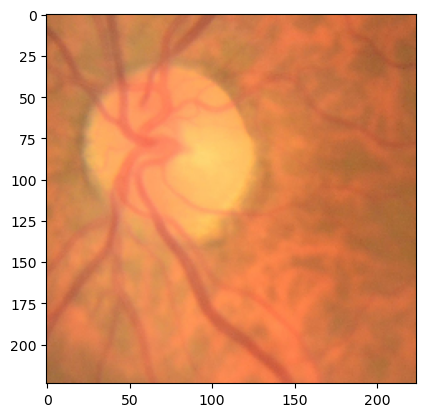

In [17]:
data = ClassifierDataset("data/cfp", img_prefix = "DEV", yolo_dir="data/labels_train_finalModel", label_file="data/dev_labels.csv", start_idx=4, end_idx=8, cache_all = True,  transform = train_transforms, FACTOR = 2)
dataloader = DataLoader(data, batch_size=2)
batch = next(iter(dataloader))
plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()

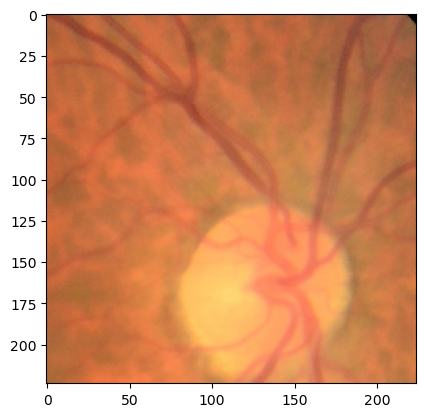

In [16]:
data = ClassifierDataset("data/cfp", img_prefix = "DEV", yolo_dir="data/labels_train_finalModel", label_file=None, start_idx=4, end_idx=8, cache_all = True,  transform = train_transforms, FACTOR = 2)
dataloader = DataLoader(data, batch_size=2)
batch = next(iter(dataloader))
plt.imshow(batch[0].permute(1, 2, 0)[:,:,[2,1,0]])
plt.show()